## Anisotropic Fast Marching Methods ##
Experimenting with finding the shortest path through an anisotropic medium.

Papers being referenced: 
- https://hal.archives-ouvertes.fr/hal-01778322/document
- https://hal.archives-ouvertes.fr/hal-01507334v4/document

GitHub repository with source algorithm: 
- https://github.com/Mirebeau/AdaptiveGridDiscretizations

Demo Jupyter Notebooks:
- https://nbviewer.jupyter.org/github/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_FMM/Riemannian.ipynb



### Setup ###
First install the necessary packages.<br>
Clone the AGD repository from GitHub, then create an environment using the environment file: <br>
`conda env create --file agd-hfm.yaml` <br>
    
Or install directly with conda: <br>
`conda install agd -c agd-lbr`


In [1]:
import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.Plotting import quiver
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
norm_infinity = ad.Optimization.norm_infinity
import sys
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mayavi import mlab # Plots implicit surfaces in 3D
import pyevtk
%matplotlib inline

In [2]:
def crop2topo(grid, dem, a=None):
    '''Crop gempy lith_block to land surface using an imported DEM raster file.
    
    Inputs:
    grid:   list [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    dem:    array of elevation values, of same xy dimensions as model, to be used for cropping.
    a:      optional: array to be cropped if not using gempy (e.g. as provided by mapping.crop2raster())
            must already be of dimensions (xres,yres,zres)
              
    Output:
    gcrop:    cropped lith_block array'''

    #Get coordinate info from grid & create VTK cells info in coord system instead of in cell indices:
    xmin = grid[0]   #min (left) coordinate
    xmax = grid[1]   #max (right) coordinate
    xres = grid[2]   #number of pixels
    ymin = grid[3]
    ymax = grid[4]
    yres = grid[5]
    zmin = grid[6]   #important: need zmin of model, NOT just DEM: model may extend below lowest point at land surface
    zmax = grid[7]
    zres = grid[8]
        
    dx   = (xmax-xmin)/xres                       #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)            #coordinates of column edges (borders between pixels)
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Get DEM & convert to topo array:
    dema = dem
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (must first convert array to float)        
    t = dema.copy()              #make a copy of elevation values directly from dem (do not use topo grid - different indexing!)

    #Get lith array:
    g = a.copy()                         #use array (make copy) (must already be 3D)
    g = g.round()                        #round to integers

    #Check dimensions for debugging:
    #print('topo shape:\t', t.shape)
    #print('lith shape:\t', g.shape)
    #print('topo min:\t',   t.min(), np.unravel_index(t.argmin(), t.shape)) #show indices of min/max of topography
    #print('topo max:\t',   t.max(), np.unravel_index(t.argmax(), t.shape))
    #print('model min:\t',  zmin) #show min/max of entire model
    #print('model max:\t',  zmax)

    #Get z indices of land surface:
    ind = (t - zmin) / dz              #calculate the cell index of each point in the dem array using the cell height (i.e. how many cells/layers up it is from the base)
    #ind = ind - 1                      #bump down by one to represent bottom of cell (this cuts lower than actual topo) 
    ind[ind==-1] = 0                   #zeros should stay zeros and not go negative
    ind = np.ceil(ind)                 #round up to nearest integer 
    ind = ind.astype(int)              #convert to integers for use as vertical indices
    #print('ind:\t', ind.shape, type(ind)) #debugging
    #print(np.unique(ind))

    #Crop off everything above the land surface:
    m = np.zeros((xres,yres))  #create array of zeroes of shape (xres,yres)
    gcrop = g.copy()           #make a copy bc need original as reference
    for x in range(xres):      #loop over x,y indices
        for y in range(yres):
            try:
                z = ind[x,y]            #get land surface elev at point (x,y)
                #m[x,y] = g[x,y,z]       #get lith value at land surface at point (x,y) - only if want to return a map
                gcrop[x,y,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
            except:
                z = ind[y,x]
                gcrop[y,x,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
    #print('map:\t', m.shape)       #for debugging
    #print('crop:\t', gcrop.shape)
    return gcrop


def export2vtk(sol, vtk_path, a=None):
    '''Export gempy lith_block array to VTK file (for viewing in e.g. ParaView).
    
    Inputs:
    sol:      list of model dimensions [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    vtk_path: filepath to save VTK file to (must not include any file extension)
    a:        array to export (such as a cropped lith_block)
    
    Returns:
    VTK file representing the exported array'''
    
    #Get coordinate info from grid & create VTK cells info:
    xmin = sol[0]        #min coordinate value (left)
    xmax = sol[1]        #max coordinate value (right)
    xres = sol[2]        #number of pixels
    ymin = sol[3]
    ymax = sol[4]
    yres = sol[5]
    zmin = sol[6]
    zmax = sol[7]
    zres = sol[8]
        
    dx   = (xmax-xmin)/xres                       #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)            #calculate x coordinate values of the boundaries between cells
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Format array for export:
    g = a.copy()                         #make a copy to avoid messing up original

    
    #Debugging checks:
    #print('x:', xmin,xmax,xres,dx)
    #print('y:', ymin,ymax,yres,dy)
    #print('z:', zmin,zmax,zres,dz)
    #print('shape of array to export:', g.shape)
    #plt.imshow(g[:,:,0])
    
    pyevtk.hl.gridToVTK(vtk_path, xvals, yvals, zvals, cellData={'data': g}) #export to VTK
    
def export2gslib(a, filename, grid):
    '''Exports a numpy array to a gslib file (GeoModeller-style format), using gempy grid objects to get the correct dimensions.
    
    Inputs: 
    a:        numpy array to be exported 
    filename: filename or path to save to
    grid:     [xres,yres,zres]
    
    Output: 
    filename.gslib: a gslib file
    '''
    
    #Format data:
    a[np.isnan(a)] = 0              #assign zeros to nan values (for SKS)
    a = np.round(a)                 #round to integers
    a = a.astype(int)               #convert from floats to integers (so that gslib file will have integers)
    
    #Get grid info
    xres = grid[0]                          #get x resolution
    yres = grid[1]                          #get y resolution
    if len(grid)==3:                        #if 3D grid
        zres = grid[2]                      #get z resolution
       
    #Format array shape:
    try:                                                #try to reshape in 3D
        a = np.reshape(a,(xres,yres,zres))              #reshape 1D array to a 3D array with correct dimensions
        a = np.reshape(a, xres*yres*zres, order='F')    #reshape 3D array back to 1D array using Fortran indexing 
    except:                                             #if 3D doesn't work, try 2D 
        a = np.reshape(a,(xres,yres))                   #reshape 1D array to a 2D array with correct dimensions
        a = np.reshape(a, xres*yres, order='F')         #reshape 2D array back to 1D array using Fortran indexing 
        
    #Export:    
    df = pd.DataFrame(a)                            #store array in a pandas dataframe
    header = pd.DataFrame(['Geologic model',1,'lith'])    #set gslib file header
    df = header.append(df)                              #attach header and data
    df.to_csv(filename, header=False, index=False)      #write a text file in gslib format


### Isotropic Fast Marching example ###
Simple explanation here: https://math.berkeley.edu/~sethian/2006/Explanations/fast_marching_explain.html



DEM array: (100, 80) 252.5 600.0
DEM indices: (100, 80) 24 59
Contact surface: (100, 80) 311.0 450.0
Contact indices: (100, 80) 30.0 43.0
Geology array: (100, 80, 60) 1.0 2.0
Geologic map: (100, 80) 1.0 2.0
Spring indices: [55, 40, 35] Spring coord: [555. 405. 355.]
Cropped geology: (100, 80, 60) 0.0 2.0


Text(0.5, 0, 'x-sec at spring Z location')

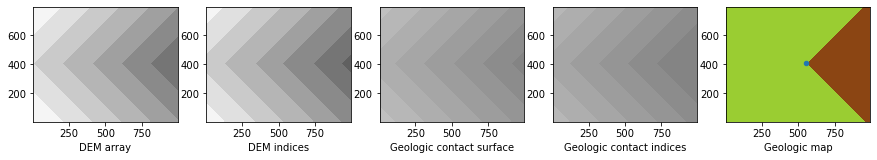

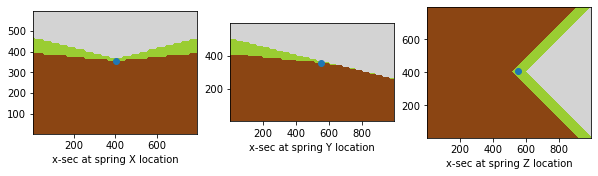

In [3]:
#Create input object:
hfmIn = Eikonal.dictIn({   # Create a dictionary-like structure to store the input data
    'model': 'Isotropic3', # Isotropic eikonal equation (use Isotropic2 for 2D, Isotropic3 for 3D)
    'order':  2.,          # Use a second order scheme, so as to increase accuracy
    'cost':   1.           # Unit cost for now. A position dependent cost function is also considered below.
    #'speed': 1.           # One may equivalently provide a speed function. In that case cost = 1/speed.
})

#Set grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]], dims=[xres,yres,zres])  #create a grid with sides [xmin,xmax],[ymin,ymax] and dims (height/gridScale, width/gridScale)
X,Y,Z = hfmIn.Grid()                                  #create a coordinate system (two arrays of the X and Y values (respectively) at each point in the grid)

#Create topography array:
dema = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):                 #move west to east along x indices (columns)
    dema[ix,:] = mx*ix + dema[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):       #move down rows towards valley (north to south)
        dema[ix,iy] = my*iy + dema[ix,0]    #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):               #move down y indices (rows) away from valley (south to north)
    dema[:,iy] = dema[:,yres-iy]            #insert a mirror image of the north side of the valley
f = plt.figure(figsize=(15,5))
f.add_subplot(151, aspect='equal')
#plt.imshow(dema, vmin=zmin, vmax=zmax, cmap='gist_earth')
plt.contourf(X[:,:,0],Y[:,:,0], dema, cmap='gray', vmin=zmin,vmax=zmax) #darker=lower
plt.xlabel('DEM array')
print('DEM array:', dema.shape, dema.min(), dema.max())

#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dema[:,iy]):
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        idem[ix,iy] = zind-1 #correct to be index below
f.add_subplot(152, aspect='equal')
#plt.imshow(idem, vmin=zmin, vmax=zmax, cmap='gist_gray') 
plt.contourf(X[:,:,0],Y[:,:,0], idem, cmap='gray', vmin=0,vmax=zres)  #0=bottom,black, 1=top,white
plt.xlabel('DEM indices')
print('DEM indices:', idem.shape, idem.min(), idem.max())

#Create geologic contact surface elevation array:
zstart = zmax - (zmax-zmin)//4
zcontact = np.full((xres,yres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.1 * dx                 #set the slope in the x direction (west to east)
my = -0.1 * dy                 #set the slope in the y direction (north to south)
valley  = yres//2              #set which row to put the valley in
for ix in range(xres):                        #move west to east along columns
    zcontact[ix,:] = mx*ix + zcontact[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(ymin,valley+1):           #move down rows towards valley (north to south)
        zcontact[ix,iy] = my*iy + zcontact[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):                      #move down rows away from valley (south to north)
    zcontact[:,iy] = zcontact[:,yres-iy]           #insert a mirror image of the north side of the valley
f.add_subplot(153, aspect='equal')
#plt.imshow(zcontact, vmin=zmin, vmax=zmax, cmap='gray')
plt.contourf(X[:,:,0],Y[:,:,0], zcontact, cmap='gray', vmin=zmin,vmax=zmax)  
plt.xlabel('Geologic contact surface')
print('Contact surface:', zcontact.shape, zcontact.min(), zcontact.max())

#Convert from elevations to cell z indices:
icontact = np.empty((xres,yres))
#for row in range(yres):
    #_,_,icontact[row,:] = mapping.xyz2rowcollay([],[], zcontact[row,:], [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax])
for iy in range(yres):
    for ix,z in enumerate(zcontact[:,iy]):
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        icontact[ix,iy] = zind - 1
f.add_subplot(154, aspect='equal')
#plt.imshow(icontact, vmin=zmin, vmax=zmax, cmap='gist_gray')
plt.contourf(X[:,:,0],Y[:,:,0], icontact, cmap='gray', vmin=0,vmax=zres)  
plt.xlabel('Geologic contact indices')
print('Contact indices:', icontact.shape, icontact.min(), icontact.max())

#Create 3D geology array (the integer in each cell indicates the formation present in that cell):
#Important: layer 0 is at the top, layer 60 is at the bottom (NOT vice-versa)
geo = np.empty((xres,yres,zres))   #set empty 3D array of model dimensions
for ix in range(xres):            #loop over cols, rows, & layers
    for iy in range(yres):
        for iz in range(zres):             #for each cell, 
            if iz <= icontact[ix,iy]:    #if layer is below the contact index (i.e. has a lower index),
                geo[ix,iy,iz] = 2        #assign 2 for shale
            if iz > icontact[ix,iy]:     #if layer is above the contact index (i.e. has a higher index),
                geo[ix,iy,iz] = 1        #assign 1 for limestone
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geo', a=geo)
print('Geology array:', geo.shape, geo.min(), geo.max())    
    
#Create geologic map
geomap = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        geomap[ix,iy] = geo[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface
f.add_subplot(155, aspect='equal')
cmap = matplotlib.colors.ListedColormap(['lightgray','yellowgreen','saddlebrown']) #create custom colormap
#plt.imshow(geomap, cmap=cmap, vmin=0, vmax=2)                
plt.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=2)   #0:nan, gray, 1: limestone, green 2: shale, brown  
plt.xlabel('Geologic map')
print('Geologic map:', geomap.shape, geomap.min(), geomap.max())

#Define spring:
ispring = [55,40]            #ix,iy 
zspring = idem[ispring[0],ispring[1]]        #get surface elevation index of spring from topo array
ispring.append(int(zspring))
springXYZ = hfmIn.PointFromIndex([ispring[0],ispring[1],ispring[2]])
plt.scatter(springXYZ[0], springXYZ[1], s=20)    #show spring location
print('Spring indices:',ispring, 'Spring coord:', springXYZ)
#print('Note: z looks like it should be 36, not 42. Why?')
springdf = pd.DataFrame(springXYZ,index=['x','y','z']).T
springdf.to_csv('spring.csv',header=True,index=False)

#Crop:
geocrop  = crop2topo([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], dema, geo)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geocrop', a=geocrop)  #export for ParaView
export2gslib(geocrop, 'geocrop.gslib', [xres,yres,zres])    #export to GSLIB for SKS

print('Cropped geology:', geocrop.shape, geocrop.min(), geocrop.max() )

#Plot sliced views:
f,ax = plt.subplots(1,3, figsize=(10,5), subplot_kw={'aspect':'equal'})
#ax[0].imshow(lithZcrop[ispring[1],:,:], cmap=cmap, vmin=0, vmax=2)  #E-W x-sec 
ax[0].contourf(Y[0,:,:],Z[0,:,:], geocrop[ispring[0],:,:], cmap=cmap, vmin=0,vmax=2)   #0:nan, gray, 1: limestone, green 2: shale, brown  
ax[0].scatter(springXYZ[1],springXYZ[2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
#ax[1].imshow(lithZcrop[:,ispring[0],:], cmap=cmap, vmin=0, vmax=2)  #N-S xsec
ax[1].contourf(X[:,0,:],Z[:,0,:], geocrop[:,ispring[1],:], cmap=cmap, vmin=0,vmax=2)
ax[1].scatter(springXYZ[0],springXYZ[2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
#ax[2].imshow(lithZcrop[:,:,ispring[2]], cmap=cmap, vmin=0, vmax=2)            #top view after topo cropping (layer 0 = bottom, layer 59 = top)
ax[2].contourf(X[:,:,0],Y[:,:,0], geocrop[:,:,ispring[2]], cmap=cmap, vmin=0,vmax=2)
ax[2].scatter(springXYZ[0],springXYZ[1])
ax[2].set_xlabel('x-sec at spring Z location')

In [4]:
#Define the target points (the seeds, at which travel time = 0):
hfmIn.update({
    'seeds':[[springXYZ[0],springXYZ[1],springXYZ[2]]],  # Introduce seeds, at positions [[x1,y1],[x2,y2],...] (will be rounded to closest grid point)
    'seedValues':[0.],           # Boundary conditions imposed at the seeds. (?)
    # 'seedValues' defaults [0.] if unspecified. 
})
index,rounding_error = hfmIn.IndexFromPoint(hfmIn['seeds'])  #get rounded indices of seeds in grid
print(f"Seed grid indices rounded to {index}, with rounding errors {rounding_error}")
print(f"Rounded positions {hfmIn.PointFromIndex(index)}, original positions {hfmIn.PointFromIndex(index+rounding_error)}") #get back original positions if needed

#Indicate desired outputs:
hfmIn['exportValues'] = 1.         # Ask for the PDE solution
hfmIn['exportGeodesicFlow'] = 1    # Ask for the geodesic flow 
hfmIn

Seed grid indices rounded to [[55 40 35]], with rounding errors [[0. 0. 0.]]
Rounded positions [[555. 405. 355.]], original positions [[555. 405. 355.]]


dictIn({'arrayOrdering': 'RowMajor', 'model': 'Isotropic3', 'order': 2.0, 'cost': array(1.), 'gridScales': array([10., 10., 10.]), 'dims': array([100.,  80.,  60.]), 'origin': array([0., 0., 0.]), 'seeds': array([[555., 405., 355.]]), 'seedValues': array([0.]), 'exportValues': 1.0, 'exportGeodesicFlow': 1})

tips: (5, 3) [[315.  55. 495.]
 [ 75. 665. 535.]
 [ 45. 785. 575.]
 [365. 745. 485.]
 [125. 415. 465.]]


Text(0.5, 0, 'x-sec at spring Z location')

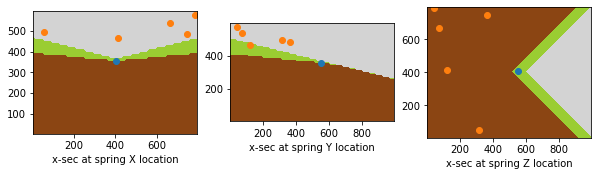

In [5]:
#Define the starting points (tips) for walker path calculations (in this case, the inlets):
ntips = 5                                      #number of start points to generate
tips = []
for i in range(ntips):                         #generate random starting points
    ix = random.randrange(0,int(ispring[0]))   #get random x integer 
    iy = random.randrange(0,yres)              #get random y integer upgradient of spring
    iz = idem[ix,iy]                           #get land surface index
    [x,y,z] = hfmIn.PointFromIndex([ix,iy,iz])  #convert indices to coordinates
    tip = [x,y,z]                               #for 3d, tip = [x,y,z]        
    tips.append(tip)
tips = np.array(tips)
print('tips:', np.shape(tips), tips)
hfmIn['tips'] = tips # Ask for the geodesics from specified points (these are the points where walkers would start from to reach the seeds)
tipsdf = pd.DataFrame(tips, columns=['x','y','z'], index=np.arange(len(tips)))
tipsdf.to_csv('tips.csv',header=True,index=False)

#Plot locations of starting and ending points:
f,ax = plt.subplots(1,3, figsize=(10,5), subplot_kw={'aspect':'equal'})
ax[0].contourf(Y[0,:,:],Z[0,:,:], geocrop[ispring[0],:,:], cmap=cmap, vmin=0,vmax=2)   #0:nan, gray, 1: limestone, green 2: shale, brown  
ax[0].scatter(springXYZ[1],springXYZ[2])  #spring 
ax[0].scatter(tips[:,1],tips[:,2])  
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], geocrop[:,ispring[1],:], cmap=cmap, vmin=0,vmax=2)
ax[1].scatter(springXYZ[0],springXYZ[2]) #spring
ax[1].scatter(tips[:,0],tips[:,2])  
ax[1].set_xlabel('x-sec at spring Y location')
ax[2].contourf(X[:,:,0],Y[:,:,0], geocrop[:,:,ispring[2]], cmap=cmap, vmin=0,vmax=2)
ax[2].scatter(springXYZ[0],springXYZ[1])
ax[2].scatter(tips[:,0],tips[:,1])  
ax[2].set_xlabel('x-sec at spring Z location')

In [6]:
# Run the solver:
#hfmIn['stopWhenAllAccepted']=hfmIn['tips'] # Abort computation when all the tips are reached by the front
hfmOut = hfmIn.Run()
print("Output keys : ", hfmOut.keys(),"\n")  #view keys for getting outputs

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.541 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Output keys :  dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'flow', 'geodesics', 'nAccepted', 'unusedFromCompute', 'values', 'visitedUnset']) 



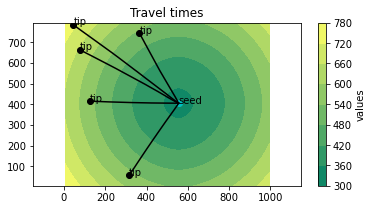

In [7]:
#Plot a contour map of travel times to the seeds (t=0 at the seed):
f = plt.figure(figsize=[6,3])
plt.title('Travel times')
plt.axis('equal')
z = 0
v = plt.contourf(X[:,:,z],Y[:,:,z],hfmOut['values'][:,:,z], cmap='summer'); # Display the value function at a specified z location
cbar = f.colorbar(v)
cbar.ax.set_ylabel('values')

#Plot seeds & tips:
seedX = hfmIn['seeds'][:,0]         #get seed & tip coordinates
seedY = hfmIn['seeds'][:,1]
tipX = hfmIn['tips'][:,0]
tipY = hfmIn['tips'][:,1]
plt.scatter(seedX,seedY, c='c')    #plot seed point
plt.scatter(tipX,tipY,   c='k')    #plot origin points
for i in range(len(seedX)):
    plt.annotate('seed',(seedX[i],seedY[i]))  #label points
for i in range(len(tipX)):
    plt.annotate('tip',(tipX[i],tipY[i]))     #label points

# Draw the geodesics (the shortest path from tip to seed)
paths = hfmOut['geodesics']
for path in paths:                #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(pathX,pathY,c='k')   #plot as lines
pathsa = np.concatenate(paths, axis=1)                   #concatenate into array
pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T
pathsdf.to_csv('paths.csv',header=True,index=False)       #export to csv for ParaView


In [8]:
#Plot in 3D:
#Travel time:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
mlab.contour3d(X,Y,Z, hfmOut['values'], contours=contours, opacity=0.75, colormap='summer')

#Plot land surface:
mlab.surf(X[:,:,0],Y[:,:,0], dema, colormap='gray')
#Plot contact surface:
mlab.surf(X[:,:,0],Y[:,:,0], zcontact, colormap='gray')

#Shortest paths:
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    mlab.plot3d(pathX,pathY,pathZ, color=(0,0,0), tube_radius=1*dx) #plot paths

#Top of watershed:
mlab.plot3d([0,0],[400,400],[500,600], color=(0,0,0), tube_radius=1*dx)  #plot short vertical line at upper western midline of area
mlab.show() # Displays in an external window. 


**Introduce position-dependent cost:**

Some locations are easier to move through than others (ex: limestone vs. shale)

Text(0, 0.5, 'cost')

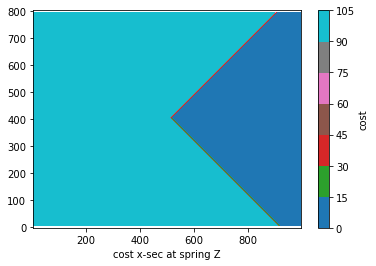

In [9]:
#Define cost function & view:
#0: nan, 1: limestone 2: shale  
#higher cost = slower to travel through
#cost = np.rot90(lithZcrop, axes=[1,0])
cost = geocrop.copy()
cost[np.isnan(cost)] = 999  #assign very high cost to areas outside model boundary
cost[cost==1] = 1        #assign low cost to limestone
cost[cost==2] = 100       #assign higher cost to shale
hfmIn['cost'] =  cost  #cost is an array of dim(xres,yres) with the value in each cell indicating how difficult it is to move through that cell (higher value=harder to move)
f = plt.figure()
v = plt.contourf(X[:,:,ispring[2]],Y[:,:,ispring[2]],hfmIn['cost'][:,:,ispring[2]], cmap='tab10') #plot x-sec at spring elev
plt.scatter(springXYZ[0],springXYZ[1])
plt.axis('equal')
plt.xlabel('cost x-sec at spring Z')
cbar = f.colorbar(v)
cbar.ax.set_ylabel('cost')

In [10]:
#Run:
#hfmIn['stopWhenAllAccepted']=hfmIn['tips'] # Abort computation when all the tips are reached by the front
hfmOut =hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.563 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


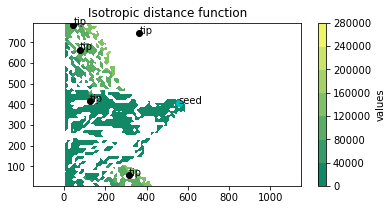

In [11]:
#View output:
#Plot a contour map of travel times to the seeds (t=0 at the seed):
f = plt.figure(figsize=[6,3]); plt.title('Isotropic distance function'); plt.axis('equal');
z = ispring[2]
v = plt.contourf(X[:,:,z],Y[:,:,z],hfmOut['values'][:,:,z], cmap='summer'); # Display the value function.
cbar = f.colorbar(v)
cbar.ax.set_ylabel('values')

#Plot seeds & tips:
seedX = hfmIn['seeds'][:,0]         #get seed & tip coordinates
seedY = hfmIn['seeds'][:,1]
tipX = hfmIn['tips'][:,0]
tipY = hfmIn['tips'][:,1]
plt.scatter(seedX,seedY, c='c')    #plot seed points
plt.scatter(tipX,tipY,   c='k')    #plot origin point
for i in range(len(seedX)):
    plt.annotate('seed',(seedX[i],seedY[i]))  #label points
for i in range(len(tipX)):
    plt.annotate('tip',(tipX[i],tipY[i]))     #label points

# Draw the geodesics (the shortest path from tip to seed)
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(pathX,pathY,c='k')   #plot as lines
pathsa = np.concatenate(paths, axis=1)                   #concatenate into array
pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T
pathsdf.to_csv('paths_costf.csv',header=True,index=False)       #export to csv for ParaView


In [12]:
#Plot in 3D:
#Travel time:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
mlab.contour3d(X,Y,Z, hfmOut['values'], contours=contours, opacity=0.5)

#Cost:
contours = np.linspace(np.min(hfmIn['cost']), np.max(hfmIn['cost']), num=2).tolist() #generate contours
mlab.contour3d(X,Y,Z, hfmIn['cost'], contours=contours)  #plot travel time

#Plot land surface:
mlab.surf(X[:,:,0],Y[:,:,0], dema, colormap='gray')
#Plot contact surface:
mlab.surf(X[:,:,0],Y[:,:,0], zcontact, colormap='gray')

#Shortest paths:
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    mlab.plot3d(pathX,pathY,pathZ, color=(0,0,0), tube_radius=1) #plot paths
mlab.plot3d([0,0],[400,400],[500,600], color=(0,0,0), tube_radius=1*dx)  #plot short vertical line at upper western midline of area

mlab.show() # Displays in an external window. 


# WORKING AREA #

**Introduce 2-step process: first to water table, then to spring**

In [13]:
#Create input object:
hfmIn = Eikonal.dictIn({   # Create a dictionary-like structure to store the input data
    'model': 'Isotropic3', # Isotropic eikonal equation (use Isotropic2 for 2D, Isotropic3 for 3D)
    'order':  2.,          # Use a second order scheme, so as to increase accuracy
    #'cost':   1.           # Unit cost 
    'cost':   cost         # Position dependent cost function 
    #'speed': 1.           # One may equivalently provide a speed function. In that case cost = 1/speed.
})

#Create grid:
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]], dims=[xres,yres,zres])  #create a grid with sides [xmin,xmax],[ymin,ymax] and dims (height/gridScale, width/gridScale)
X,Y,Z = hfmIn.Grid()                                  #create a coordinate system (two arrays of the X and Y values (respectively) at each point in the grid)

#Define the target points (the seeds, at which travel time = 0):
#seeds = [springXYZ[0],springXYZ[1],springXYZ[2]]    #seed is spring
#seed is a different location:
iseed = [ispring[0]+25,ispring[1]]     #ix,iy 
zseed = idem[iseed[0],iseed[1]]        #get surface elevation index of spring from topo array
iseed.append(int(zseed))
seeds = hfmIn.PointFromIndex([iseed[0],iseed[1],iseed[2]])
seeddf = pd.DataFrame(seeds,index=['x','y','z']).T   #export to csv
seeddf.to_csv('seeds.csv',header=True,index=False)
hfmIn.update({
    'seeds':[seeds],  # Introduce seeds, at positions [[x1,y1],[x2,y2],...] (will be rounded to closest grid point)
    'seedValues':[0.],           # Boundary conditions imposed at the seeds. (?)
    # 'seedValues' defaults [0.] if unspecified. 
})
index,rounding_error = hfmIn.IndexFromPoint(hfmIn['seeds'])  #get rounded indices of seeds in grid
print(f"Seed grid indices rounded to {index}, with rounding errors {rounding_error}")
print(f"Rounded positions {hfmIn.PointFromIndex(index)}, original positions {hfmIn.PointFromIndex(index+rounding_error)}") #get back original positions if needed

#Indicate desired outputs:
hfmIn['exportValues'] = 1.         # Ask for the PDE solution
hfmIn['exportGeodesicFlow'] = 1    # Ask for the geodesic flow 

#Define the starting points for walker path calculations (in this case, the inlets):
generate = False          #choose whether to generate random starting points or load existing from file
elev     = 'bottom'       #choose whether to start at land surface ('top') or bottom of karst ('bottom')
if generate: 
    print('generating new starting points')
    ntips = 10                                     #number of start points to generate
    tips = []
    for i in range(ntips):                         #generate random starting points
        ix = random.randrange(0,int(ispring[0]))   #get random x integer upgradient of spring
        iy = random.randrange(0,yres)              #get random y integer
        [x,y,z] = hfmIn.PointFromIndex([ix,iy,0])  #convert indices to coordinates with dummy z
        tip = [x,y,z]                              #for 3d, tip = [x,y,z]        
        tips.append(tip)                           #store
    tips = np.array(tips)                          #convert to array

else:
    print('loading starting points')
    tips = pd.read_csv('tips.csv').values          #load tips from csv and convert to array       
    
print('calculating elevations')
for i in range(len(tips)):
    x = tips[i,0]                              #get x coord
    y = tips[i,1]                              #get y coord
    [ix,iy,iz],error = hfmIn.IndexFromPoint([x,y,0]) #convert to indices with dummy z values
    if elev=='top':
        iz = idem[ix,iy]                      #get land surface index
    if elev=='bottom':
        iz = ispring[2]                       #get spring z elevation to start at water table
        #print('starting index', col,row,lay, 'unit', geo[col,row,lay])
        while geo[ix,iy,iz] > 1:      #if the point is below the karst unit (karst=1, unit numbers increase going down)
            iz = iz + 1               #move up by one (0 is bottom?)
            #print('point is below karst unit - move index up one', col,row,lay, 'unit', geo[col,row,lay])
            if iz > zres:             #if exit upper model boundary
                #print('exited upper model boundary - reset to spring elevation')
                iz = ispring[2]       #reset to spring elevation
                break                 #exit while loop
        #print('ending index', col,row,lay,'unit', geo[col,row,lay])
    [x,y,z] = hfmIn.PointFromIndex([ix,iy,iz])  #convert indices back to coordinates
    tips[i,2] = z    #store z coord

hfmIn['tips'] = tips #assign starting points for walkers
tipsdf = pd.DataFrame(tips, columns=['x','y','z'], index=np.arange(len(tips))) #convert to df for export
tipsdf.to_csv('tips.csv',header=True,index=False) #export to csv for saving and viewing 
print('tips:')
tips


Seed grid indices rounded to [[80 40 29]], with rounding errors [[0. 0. 0.]]
Rounded positions [[805. 405. 295.]], original positions [[805. 405. 295.]]
loading starting points
calculating elevations
tips:


array([[315.,  55., 415.],
       [ 75., 665., 425.],
       [ 45., 785., 445.],
       [365., 745., 405.],
       [125., 415., 395.]])

In [14]:
# Run the solver:
#hfmIn['stopWhenAllAccepted']=hfmIn['tips'] # Abort computation when all the tips are reached by the front
hfmOut = hfmIn.Run()
print("Output keys : ", hfmOut.keys(),"\n")  #view keys for getting outputs

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.615 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Output keys :  dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'flow', 'geodesics', 'nAccepted', 'unusedFromCompute', 'values', 'visitedUnset']) 



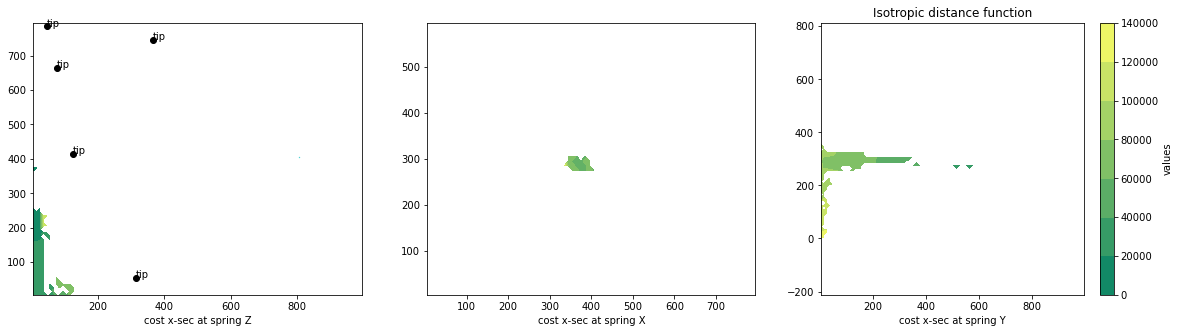

In [15]:
#View output:
#Plot a contour map of travel times to the seeds (t=0 at the seed):
f,ax = plt.subplots(1,3,figsize=[20,5]); plt.title('Isotropic distance function'); plt.axis('equal');
z = ispring[2]
v = ax[0].contourf(X[:,:,z],Y[:,:,z],hfmOut['values'][:,:,z], cmap='summer'); # Display the value function.
v = ax[1].contourf(Y[ispring[0],:,:],Z[ispring[0],:,:],hfmOut['values'][ispring[0],:,:], cmap='summer'); # Display the value function.
v = ax[2].contourf(X[:,ispring[1],:],Z[:,ispring[1],:],hfmOut['values'][:,ispring[1],:], cmap='summer'); # Display the value function.
cbar = f.colorbar(v)
cbar.ax.set_ylabel('values')
ax[0].set_xlabel('cost x-sec at spring Z')
ax[1].set_xlabel('cost x-sec at spring X')
ax[2].set_xlabel('cost x-sec at spring Y')

#Plot seeds & tips:
seedX = hfmIn['seeds'][:,0]         #get seed & tip coordinates
seedY = hfmIn['seeds'][:,1]
seedZ = hfmIn['seeds'][:,2]
tipX = hfmIn['tips'][:,0]
tipY = hfmIn['tips'][:,1]
typZ = hfmIn['tips'][:,2]
ax[0].scatter(seedX,seedY, c='c', s=0.1)    #plot seed points
ax[0].scatter(tipX,tipY,   c='k')    #plot origin point
for i in range(len(tipX)):
    ax[0].annotate('tip',(tipX[i],tipY[i]))     #label points

# Draw the geodesics (the shortest path from tip to seed)
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    ax[0].plot(pathX,pathY,c='k')   #plot as lines
    ax[1].plot(pathY,pathZ,c='k')   #plot as lines
    ax[2].plot(pathX,pathZ,c='k')   #plot as lines
pathsa = np.concatenate(paths, axis=1)                   #concatenate into array
pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T
pathsdf.to_csv('paths.csv',header=True,index=False)       #export to csv for ParaView


In [16]:
#Plot in 3D:
#Travel time:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
mlab.contour3d(X,Y,Z, hfmOut['values'], contours=contours, opacity=0.5)

#Cost:
contours = np.linspace(np.min(hfmIn['cost']), np.max(hfmIn['cost']), num=2).tolist() #generate contours
mlab.contour3d(X,Y,Z, hfmIn['cost'], contours=contours)  #plot travel time

#Plot land surface:
mlab.surf(X[:,:,0],Y[:,:,0], dema, colormap='gray')
#Plot contact surface:
mlab.surf(X[:,:,0],Y[:,:,0], zcontact, colormap='gray')

#Shortest paths:
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    mlab.plot3d(pathX,pathY,pathZ, color=(0,0,0), tube_radius=1) #plot paths
mlab.plot3d([0,0],[400,400],[500,600], color=(0,0,0), tube_radius=1*dx)  #plot short vertical line at upper western midline of area

mlab.show() # Displays in an external window. 


### Anisotropic (2D) ###

In [17]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',          # Two-dimensional Riemannian eikonal equation
    'seed':[seeds[0],seeds[1]],  # Using a single seed point in this example.
    'seedValue': 0,              # Can be omitted, since this is the default.
    'cost': geomap,              #how hard it is to travel through different formations
    'order': 2
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax]],dims=[xres,yres])


#Assign starting points for walkers:
hfmIn['tips'] = tips[:,[0,1]] #assign starting points for walkers

In [18]:
#Set anisotropy field as slope at land surface:
X,Y = hfmIn.Grid()
#Use topography:
run=True
if run:
    Z = zcontact          #dema: surface elevation array, zcontact: bottom of limestone elevation array
    DxZ,DyZ = np.gradient(Z,dx,dy,axis=(0,1))     #x and y components of gradient in each cell of array 
#Use constant rightwards gradient:
run=False
if run:
    DxZ = np.full((100,80),-0.5)   #array of constant gradient in the x direction
    DyZ = np.full((100,80),0)      #array of constant gradient in the y direction
F = Riemann.needle([DxZ,DyZ], 0.2,0.8)        #convert to format needed by hfm? need .dual() at end?
hfmIn['metric']    =  F      #assign to model

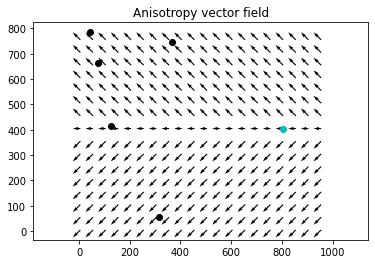

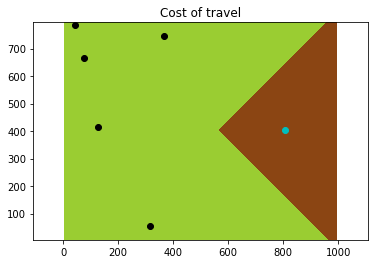

In [19]:
#Plot anisotropic vector field:
plt.figure(); 
plt.title('Anisotropy vector field')
plt.axis('equal'); 
quiver(X,Y,DxZ,DyZ,subsampling=(5,5))
plt.scatter(seeds[0],seeds[1],c='c')
plt.scatter(tips[:,0],tips[:,1],c='k')

#Plot cost:
plt.figure(); 
plt.title('Cost of travel')
plt.axis('equal'); 
plt.contourf(X,Y, hfmIn['cost'], cmap=cmap, vmin=0,vmax=2)
plt.scatter(seeds[0],seeds[1],c='c')
plt.scatter(tips[:,0],tips[:,1],c='k')

In [20]:
#Select desired outputs and run model:
hfmIn['exportValues'] = 1
hfmIn['exportGeodesicFlow'] = 1

hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.014 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


(2, 100, 80)


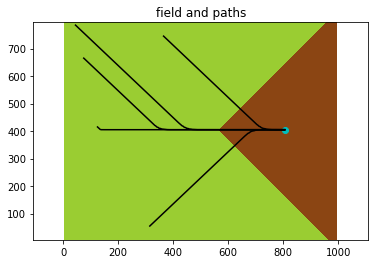

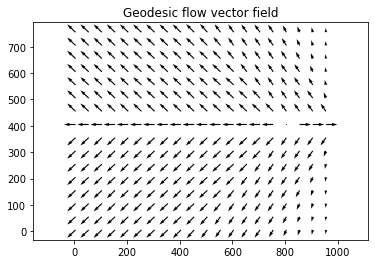

In [21]:
#Plot results:
plt.figure()
plt.title('field and paths')
plt.axis('equal')
#plt.contourf(X,Y,hfmOut['values'])   #travel time
plt.contourf(X,Y,hfmIn['cost'], cmap=cmap, vmin=0,vmax=2) #travel cost
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(*path, c='k')
plt.scatter(seeds[0],seeds[1],c='c')
    
#Plot flow field:
plt.figure(); 
plt.title('Geodesic flow vector field')
plt.axis('equal'); 
quiver(X,Y,*hfmOut['flow'],subsampling=(5,5))
print(hfmOut['flow'].shape)

### Anistotropic (3D) ###

In [22]:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', # Three-dimensional Riemannian eikonal equation
    'seed':     seeds,     # Using a single seed point in this example.
    'seedValue': 0,        # Can be omitted, since this is the default.
    'cost':      cost,     #difficulty of travel through each cell
    'order':     2
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])


#Assign starting points for walkers:
hfmIn['tips'] = tips #assign starting points for walkers

In [23]:
#Set anisotropy field:
#Must be opposite direction - will be reversed in the algorithm
X,Y,Z = hfmIn.Grid()
#stacked topo (slope at contact):
run=True
if run:
    V = np.repeat(zcontact[:,:,np.newaxis], zres, axis=2)  #create a 3D array where elevation array is repeated on each layer
    DxV,DyV,DzV = np.gradient(V, dx,dy,dz, axis=(0,1,2))     #x and y components of gradient in each cell of array 
#Uniform:
run=False
if run:
    DxV = np.full((xres,yres,zres), 0)     #array of constant gradient in the x direction
    DyV = np.full((xres,yres,zres), 0)     #array of constant gradient in the y direction
    DzV = np.full((xres,yres,zres), 0.9)   #array of constant gradient in the z direction
F = Riemann.needle([DxV,DyV,DzV], 0.2,0.8)        #convert to format needed by hfm? need .dual() at end?
hfmIn['metric']    =  F      #assign to model

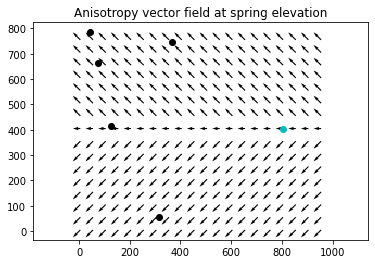

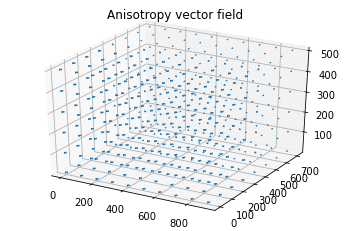

In [24]:
#Plot anisotropic vector field:
plt.figure()
plt.title('Anisotropy vector field at spring elevation')
plt.axis('equal')
quiver(X[:,:,ispring[2]],Y[:,:,ispring[2]], DxV[:,:,ispring[2]],DyV[:,:,ispring[2]], subsampling=(5,5))  #plot in 2D at spring elevation
plt.scatter(seeds[0],seeds[1],c='c')
plt.scatter(tips[:,0],tips[:,1],c='k')

#3D:
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Anisotropy vector field')
#Subsample to make plot less crowded:
subsampling=(10,10,10)
where = tuple(slice(None,None,s) for s in subsampling)
def f(A): 
    return A.__getitem__(where)
ax.quiver(f(X),f(Y),f(Z), f(DxV),f(DyV),f(DzV), length=100)

In [25]:
#Select desired outputs and run model:
hfmIn['exportValues'] = 1
hfmIn['exportGeodesicFlow'] = 1

hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.683 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


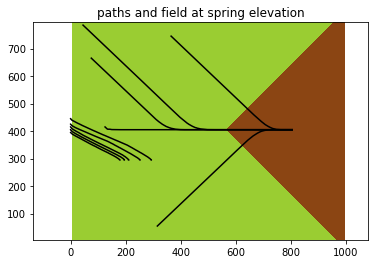

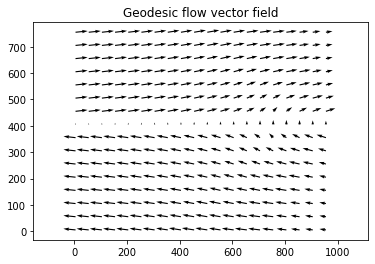

In [26]:
#Plot results:
plt.figure()
plt.title('paths and field at spring elevation')
plt.axis('equal')
#plt.contourf(X[:,:,ispring[2]],Y[:,:,ispring[2]],hfmOut['values'][:,:,ispring[2]]) #travel time
plt.contourf(X[:,:,ispring[2]],Y[:,:,ispring[2]],geomap, cmap=cmap, vmin=0,vmax=2) #travel cost
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(*path, c='k')

#Plot flow field:
plt.figure(); 
plt.title('Geodesic flow vector field')
plt.axis('equal'); 
quiver(X[:,:,ispring[2]],Y[:,:,ispring[2]], *hfmOut['flow'][[1,2],:,:,ispring[2]], subsampling=(5,5))

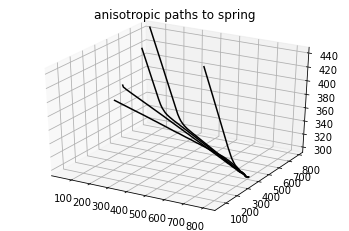

In [27]:
#Plot results in 3D:
ax = plt.figure().gca(projection='3d')
ax.set_title('anisotropic paths to spring')
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    plt.plot(*path, c='k')
pathsa = np.concatenate(paths, axis=1)                   #concatenate into array
pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T
pathsdf.to_csv('paths.csv',header=True,index=False)       #export to csv for ParaView



In [440]:
#Plot in Mayavi pop-up window:
#Travel time:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
mlab.contour3d(X,Y,Z, hfmOut['values'], contours=contours, opacity=0.25)

#Cost:
#contours = np.linspace(np.min(hfmIn['cost']), np.max(hfmIn['cost']), num=2).tolist() #generate contours
#mlab.contour3d(X,Y,Z, hfmIn['cost'], contours=contours)  #plot travel time

#Plot land surface:
#mlab.surf(X[:,:,0],Y[:,:,0], dema, colormap='gray')
#Plot contact surface:
mlab.surf(X[:,:,0],Y[:,:,0], zcontact, colormap='gray', opacity=0.5)

#Shortest paths:
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    mlab.plot3d(pathX,pathY,pathZ, color=(0,0,0), tube_radius=1) #plot paths
mlab.plot3d([0,0],[400,400],[500,600], color=(0,0,0), tube_radius=1*dx)  #plot short vertical line at upper western midline of area

mlab.show() # Displays in an external window. 
